# Train dacapo on toy example

Important: this notebooks expects the toy zarr example data to have been created.

In [12]:
# Open toy example
import zarr
image = zarr.open("../data/image.zarr")
train_crops = list(image["train"].group_keys())
val_crops = list(image["test"].group_keys())
print(f"{len(train_crops)} training crops, {len(val_crops)} validation crops")

6 training crops, 2 validation crops


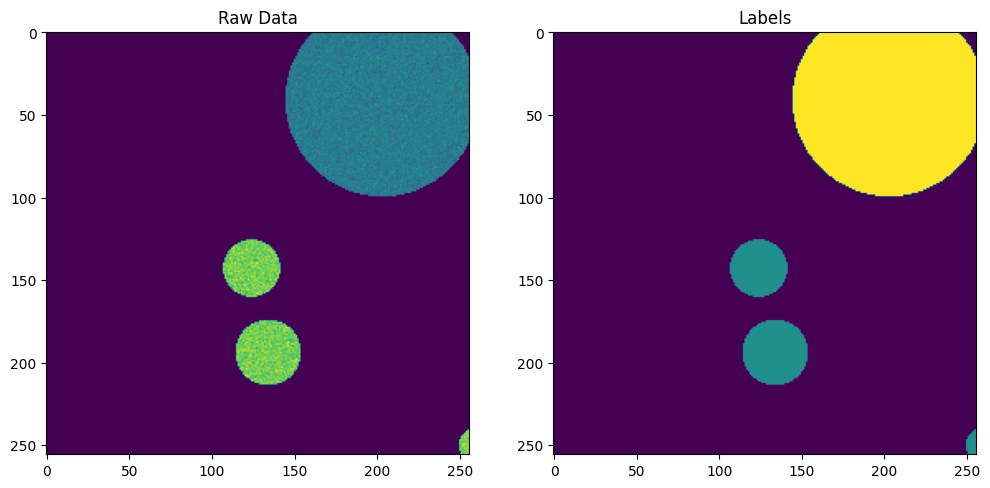

In [13]:
# Show data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show the raw data
axes[0].imshow(image["train"]["crop_00"]["raw"][50, ...])
axes[0].set_title("Raw Data")

# Show the labels using the custom label color map
axes[1].imshow(image["train"]["crop_00"]["labels"][50, ...])
axes[1].set_title("Labels")

plt.show()


In [14]:
# To avoid a bug in macOS 
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

# Create a config store to store our configurations
# Because of the dacapo.yaml file, this will be created in the /train/ folder
from dacapo.store.create_store import create_config_store
config_store = create_config_store()

Creating FileConfigStore:
	path: train_data/configs


In [15]:
# create datasplits

from dacapo.experiments.datasplits import TrainValidateDataSplitConfig
from dacapo.experiments.datasplits.datasets import RawGTDatasetConfig
from dacapo.experiments.datasplits.datasets.arrays import ZarrArrayConfig

def create_data_split(zarr_dataset):

    # get train and val
    train_crops = list(image["train"].group_keys())
    val_crops = list(image["test"].group_keys())
    
    t_crops = []
    v_crops = []
    for subfolder, lst_crop, cfg_lst in zip(
        ["train", "test"], [train_crops, val_crops], [t_crops, v_crops]
    ):
        for crop in lst_crop:
            # create zarr array config for each raw and label image
            crop_raw = ZarrArrayConfig(
                name=f"{crop}_raw",
                file_name=zarr_dataset,
                dataset=f"{subfolder}/{crop}/raw",
            )
            crop_gt = ZarrArrayConfig(
                name=f"{crop}_gt",
                file_name=zarr_dataset,
                dataset=f"{subfolder}/{crop}/labels",
            )

            # append a crop config to the list
            cfg_lst.append(
                RawGTDatasetConfig(name=crop, raw_config=crop_raw, gt_config=crop_gt)
            )

    return t_crops, v_crops
        

train_crops, val_crops = create_data_split("../data/image.zarr")

datasplit_config = TrainValidateDataSplitConfig(
    name="toy_example",
    train_configs=train_crops, 
    validate_configs=val_crops,
)
config_store.store_datasplit_config(datasplit_config)


In [16]:
# create task

from dacapo.experiments.tasks import DistanceTaskConfig

resolution = 4  # nm
# an example distance task configuration
# note that the clip_distance, tol_distance, and scale_factor are in nm
dist_task_config = DistanceTaskConfig(
    name="toy_example_dist",
    channels=["cell"],
    clip_distance=resolution * 10.0,
    tol_distance=resolution * 10.0,
    scale_factor=resolution * 20.0,
)
# if the config already exists, delete it first
# config_store.delete_task_config(dist_task_config.name)
config_store.store_task_config(dist_task_config)


In [17]:
from dacapo.experiments.architectures import CNNectomeUNetConfig

# CNNectomeUNetConfig
# input_shape: Coordinate
#     The shape of the data passed into the network during training.
# fmaps_out: int
#     The number of channels produced by your architecture.
# fmaps_in: int
#     The number of channels expected from the raw data.
# num_fmaps: int
#     The number of feature maps in the top level of the UNet.
# fmap_inc_factor: int
#     The multiplication factor for the number of feature maps for each level of the UNet.
# downsample_factors: List[Coordinate]
#     The factors to downsample the feature maps along each axis per layer.
# kernel_size_down: Optional[List[Coordinate]]
#     The size of the convolutional kernels used before downsampling in each layer.
# kernel_size_up: Optional[List[Coordinate]]
#     The size of the convolutional kernels used before upsampling in each layer.
# _eval_shape_increase: Optional[Coordinate]
#     The amount by which to increase the input size when just prediction rather than training.
#     It is generally possible to significantly increase the input size since we don't have the memory
#     constraints of the gradients, the optimizer and the batch size.
# upsample_factors: Optional[List[Coordinate]]
#     The amount by which to upsample the output of the UNet.
# constant_upsample: bool
#     Whether to use a transpose convolution or simply copy voxels to upsample.
# padding: str
#     The padding to use in convolution operations.
# use_attention: bool
#     Whether to use attention blocks in the UNet. This is supported for 2D and  3D.

# 1s in z mean no downsampling or convolving in the z direction.
architecture_config = CNNectomeUNetConfig(
    name="toy_example_unet",
    input_shape=(256, 256, 256), 
    # eval_shape_increase=(8, 32, 32),
    fmaps_in=1,
    num_fmaps=8,
    fmaps_out=2,
    fmap_inc_factor=2,
    downsample_factors=[(1, 4, 4), (1, 4, 4)], # this determines the number of levels (+1) in the UNet and the dimensions
    kernel_size_down=[[(1, 3, 3)] * 2] * 3, # len(downsample_factors) == 2 => 3 levels
    kernel_size_up=[[(1, 3, 3)] * 2] * 2, # always one level less than kernel_size_down
    constant_upsample=True,
    padding="same",
)
config_store.store_architecture_config(architecture_config)

In [18]:
# create training
from dacapo.experiments.trainers import GunpowderTrainerConfig

trainer_config = GunpowderTrainerConfig(
    name="toy_example",
    batch_size=2,
    learning_rate=0.0001,
    num_data_fetchers=1,
    snapshot_interval=10,
    min_masked=0.05,
    clip_raw=False,
)
config_store.store_trainer_config(trainer_config)

In [19]:
# RunConfig is the definition of the pipeline
from dacapo.experiments import RunConfig
from dacapo.experiments.run import Run

iterations = 1
validation_interval = 1
run_config = RunConfig(
    name="toy_example_run",
    datasplit_config=datasplit_config,
    task_config=dist_task_config,
    architecture_config=architecture_config,
    trainer_config=trainer_config,
    num_iterations=iterations,
    validation_interval=validation_interval,
    repetition=0,
)
config_store.store_run_config(run_config)

In [ ]:
# Training
from dacapo.train import train_run

run = Run(config_store.retrieve_run_config("toy_example_run"))
train_run(run)

Starting/resuming training for run toy_example_run...
Creating FileStatsStore:
	path    : train_data/stats
Current state: trained until 0/1
Creating local weights store in directory train_data


training until 1:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
(3,) * 5

(3, 3, 3, 3, 3)

```
Model(
  (architecture): CNNectomeUNet(
    (unet): CNNectomeUNetModule(
      (l_conv): ModuleList(
        (0): ConvPass(
          (conv_pass): Sequential(
            (0): Conv3d(1, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1))
            (1): ReLU()
            (2): Conv3d(8, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1))
            (3): ReLU()
          )
        )
        (1): ConvPass(
          (conv_pass): Sequential(
            (0): Conv3d(8, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
            (1): ReLU()
            (2): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
            (3): ReLU()
          )
        )
        (2): ConvPass(
          (conv_pass): Sequential(
            (0): Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1))
            (1): ReLU()
            (2): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1))
            (3): ReLU()
          )
        )
      )
      (l_down): ModuleList(
        (0-1): 2 x Downsample(
          (down): MaxPool3d(kernel_size=(1, 4, 4), stride=(1, 4, 4), padding=0, dilation=1, ceil_mode=False)
        )
      )
      (r_up): ModuleList(
        (0): ModuleList(
          (0): Upsample(
            (up): Sequential(
              (0): Upsample(scale_factor=(1.0, 4.0, 4.0), mode='nearest')
              (1): Conv3d(16, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
              (2): ReLU()
            )
          )
          (1): Upsample(
            (up): Sequential(
              (0): Upsample(scale_factor=(1.0, 4.0, 4.0), mode='nearest')
              (1): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
              (2): ReLU()
            )
          )
        )
      )
      (r_conv): ModuleList(
        (0): ModuleList(
          (0): ConvPass(
            (conv_pass): Sequential(
              (0): Conv3d(24, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (1): ReLU()
              (2): Conv3d(2, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (3): ReLU()
            )
          )
          (1): ConvPass(
            (conv_pass): Sequential(
              (0): Conv3d(32, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (1): ReLU()
              (2): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (3): ReLU()
            )
          )
        )
      )
    )
  )
  (prediction_head): Conv3d(2, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (chain): Sequential(
    (0): CNNectomeUNet(
      (unet): CNNectomeUNetModule(
        (l_conv): ModuleList(
          (0): ConvPass(
            (conv_pass): Sequential(
              (0): Conv3d(1, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (1): ReLU()
              (2): Conv3d(8, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (3): ReLU()
            )
          )
          (1): ConvPass(
            (conv_pass): Sequential(
              (0): Conv3d(8, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (1): ReLU()
              (2): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (3): ReLU()
            )
          )
          (2): ConvPass(
            (conv_pass): Sequential(
              (0): Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (1): ReLU()
              (2): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1))
              (3): ReLU()
            )
          )
        )
        (l_down): ModuleList(
          (0-1): 2 x Downsample(
            (down): MaxPool3d(kernel_size=(1, 4, 4), stride=(1, 4, 4), padding=0, dilation=1, ceil_mode=False)
          )
        )
        (r_up): ModuleList(
          (0): ModuleList(
            (0): Upsample(
              (up): Sequential(
                (0): Upsample(scale_factor=(1.0, 4.0, 4.0), mode='nearest')
                (1): Conv3d(16, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
                (2): ReLU()
              )
            )
            (1): Upsample(
              (up): Sequential(
                (0): Upsample(scale_factor=(1.0, 4.0, 4.0), mode='nearest')
                (1): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
                (2): ReLU()
              )
            )
          )
        )
        (r_conv): ModuleList(
          (0): ModuleList(
            (0): ConvPass(
              (conv_pass): Sequential(
                (0): Conv3d(24, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1))
                (1): ReLU()
                (2): Conv3d(2, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1))
                (3): ReLU()
              )
            )
            (1): ConvPass(
              (conv_pass): Sequential(
                (0): Conv3d(32, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
                (1): ReLU()
                (2): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1))
                (3): ReLU()
              )
            )
          )
        )
      )
    )
    (1): Conv3d(2, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
)
```